In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection as model_sel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

## OBTENER DATOS

In [2]:
df_diabetes=pd.read_csv("diabetes.csv",encoding="ISO-8859-1",delimiter=";")
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,74,0,0,0,0.0,0.102,22,0
1,3,80,0,0,0,0.0,0.174,22,0
2,2,84,0,0,0,0.0,0.304,21,0
3,0,94,0,0,0,0.0,0.256,25,0
4,0,102,75,23,0,0.0,0.572,21,0


In [3]:
print(df_diabetes.shape)

(768, 9)


## REGRESIÓN LOGÍSTICA

* Pertenece a los modelos de aprendizaje supervisado. 
* Es un modelo lineal para la clasificación en lugar de la regresión.
* La regresión logística es un método estadístico que trata de modelar la probabilidad de una variable cualitativa binaria (dos posibles valores) en función de una o más variables independientes.

**PREPROCESAMIENTO DE LOS DATOS**

* Se reemplazarán los valores cero de aquellas columnas que podrían tener error de registro, por la mediana de ese campo.

In [4]:
# Agrupa por la etiqueta y calcula la mediana para cada columna
medians = df_diabetes.groupby('Outcome')[["Glucose", "BMI", "BloodPressure", "SkinThickness"]].median()

# Itera a través de las columnas de interés
for col in ["Glucose", "BMI", "BloodPressure", "SkinThickness"]:
    # Reemplaza los valores iguales a 0 por las medianas correspondientes
    df_diabetes.loc[(df_diabetes[col] == 0) & (df_diabetes['Outcome'] == 0), col] = medians.loc[0, col]
    df_diabetes.loc[(df_diabetes[col] == 0) & (df_diabetes['Outcome'] == 1), col] = medians.loc[1, col]

In [5]:
# Filtra las filas donde 'Insulin' no sea igual a cero y agrupa por 'Outcome'
filtered_data = df_diabetes[df_diabetes['Insulin'] != 0]

medians = filtered_data.groupby('Outcome')['Insulin'].median()

print("Mediana de Insulin para Outcome 0:", medians.loc[0])
print("Mediana de Insulin para Outcome 1:", medians.loc[1])
print()
print(medians)

Mediana de Insulin para Outcome 0: 102.5
Mediana de Insulin para Outcome 1: 169.5

Outcome
0    102.5
1    169.5
Name: Insulin, dtype: float64


In [6]:
# Define una función que reemplace los ceros en 'Insulin' por la mediana correspondiente
def replace_insulin(row):
    if row['Insulin'] == 0:
        return medians[row['Outcome']]
    else:
        return row['Insulin']

# Aplica la función a cada fila del DataFrame
df_diabetes['Insulin'] = df_diabetes.apply(replace_insulin, axis=1)

In [7]:
#comprobaremos que los valores cero ya no están en esas columnas
print(df_diabetes.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000      768.00000  768.000000   
mean      3.845052  121.677083      72.378906       27.43099  141.753906   
std       3.369578   30.464161      12.104431        9.32146   89.100847   
min       0.000000   44.000000      24.000000        7.00000   14.000000   
25%       1.000000   99.750000      64.000000       21.00000  102.500000   
50%       3.000000  117.000000      72.000000       27.00000  102.500000   
75%       6.000000  140.250000      80.000000       32.00000  169.500000   
max      17.000000  199.000000     122.000000       99.00000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.433919                  0.471876   33.240885    0.348958  
std      6.880664                  0.331329   11.760232    0.476951  
min     18.200000                  

In [8]:
conteo_de_ceros = (df_diabetes.iloc[:, :-1] == 0).sum()

print(conteo_de_ceros)

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


**SELECCIONAR CARACTERÍSTICAS**

In [9]:
# Dividir los datos en características (X) y la variable objetivo (y)
X = df_diabetes.drop('Outcome', axis=1)  # Características

y = df_diabetes['Outcome']  # Variable objetivo

**1-DIVIDIR DATOS ENTRENAMIENTO Y TEST**    
    
**2-ESCALAR LOS DATOS**: La estandarización implica transformar las características de     
manera que tengan una media de cero y una desviación estándar de uno.    
    
La fórmula utilizada para lograrlo es la siguiente: 𝑥𝑒𝑠𝑐𝑎𝑙𝑎𝑑𝑜 = 𝑥−𝑚𝑒𝑑𝑖𝑎 / 𝑑𝑒𝑠𝑣𝑖𝑎𝑐𝑖ó𝑛 𝑠𝑡𝑎𝑛𝑑𝑎𝑟𝑑    


In [10]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
#stratify: La idea detrás de la estratificación es mantener la misma proporción de clases en ambos conjuntos, lo que es especialmente relevante cuando se trabaja con conjuntos de datos desequilibrados.
#Shufle: la práctica de presentar los datos al modelo en un orden aleatorio durante la fase de entrenamiento para evitar sesgos y mejorar la generalización y la convergencia del modelo.
#stratify=y,

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = True,  random_state=42)

# Escalar las características

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(614, 8)
(614,)
(154, 8)
(154,)


### ENTRENAMIENTO Y PREDICCIÓN

In [12]:
# Crear y entrenar el modelo de regresión logística
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [13]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

print(y_pred)

[1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1
 1 1 0 1 0 0]


## **EVALUAR EL MODELO**
* **MATRIZ DE CONFUSIÓN:** es una tabla que se utiliza en problemas de clasificación para evaluar el rendimiento de un modelo de aprendizaje automático. Esta tabla compara las predicciones del modelo con las clases reales de los datos y muestra cuántos de los resultados fueron clasificados correctamente y cuántos fueron clasificados incorrectamente.

**MÉTRICAS DE EVALUACIÓN**
* **Exactitud (Accuracy):** es la proporción de predicciones correctas (verdaderos positivos y verdaderos negativos) con respecto al total de predicciones realizadas. Es una métrica fácil de entender, pero puede no ser la mejor elección cuando las clases están desequilibradas.
* **Precisión (Precision):** mide la proporción de verdaderos positivos con respecto a todas las predicciones positivas realizadas. Es útil cuando el costo de los falsos positivos es alto y deseas minimizarlos.
 * **Recall (Recuperación o Sensibilidad):** mide la proporción de verdaderos positivos con respecto a todos los casos reales positivos en los datos. Es útil cuando el costo de los falsos negativos es alto y deseas minimizarlos.    
* **F1-Score:** es la media armónica de precisión y recall. Es útil cuando deseas equilibrar la precisión y el recall en tu evaluación. Puede ser especialmente útil en situaciones de clases desequilibradas.   

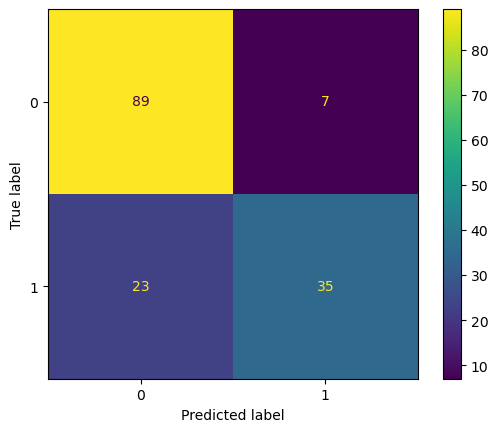

In [14]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [15]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_test, y_pred),2))
print("Precisión:", round(precision_score(y_test, y_pred),2))
print("Recall:", round(recall_score(y_test, y_pred),2))
print("F1 score:", round(f1_score(y_test, y_pred),2))

Accuracy del modelo:  0.81
Precisión: 0.83
Recall: 0.6
F1 score: 0.7


In [17]:
classification_rep = classification_report(y_test, y_pred)
print(f"\nReporte de clasificación:\n{classification_rep}")


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        96
           1       0.83      0.60      0.70        58

    accuracy                           0.81       154
   macro avg       0.81      0.77      0.78       154
weighted avg       0.81      0.81      0.80       154



**Primeras conclusiones:**    
* El modelo inicial, con datos estandarizados, obtuvo un accuracy de 0.75. En el reporte de clasificación se verifica mayor precisión en la clase predominante que es la 0. Además, en la clase 1, se verifica un recall bajo. Esta combinación suele ser frecuente en casos de clases desbalanceadas.
* Al reemplazar el valor cero en las filas que contenían posibles errores por su mediana. Se mejora el accuracy, y la f1. De todos modos sigue con mejor precisión en la clase predominante.
* Se realizó la prueba de utilizar el parámetro class_weight asignando mayor peso a la clase minoritaria, pero los resultados fueron más bajos. 

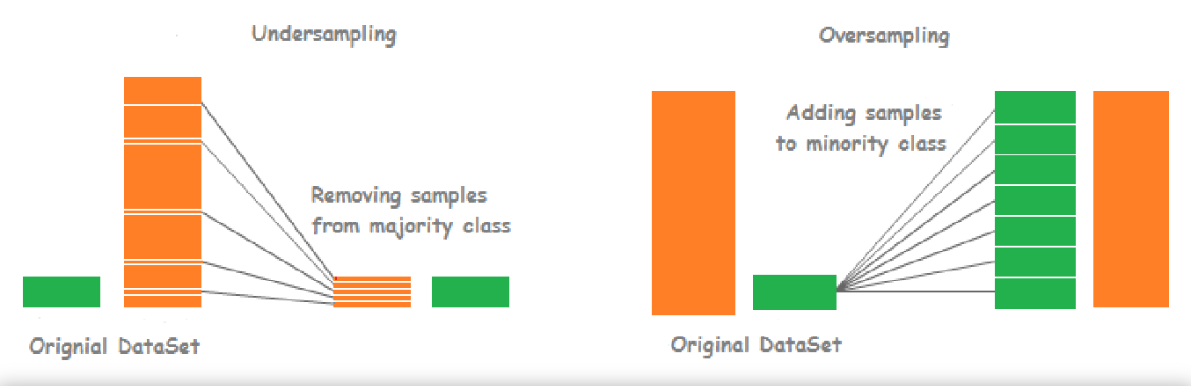

**RANDOM OVER SAMPLER:**
* Vamos a crear muestras nuevas “sintéticas” de la clase minoritaria.

In [18]:
# Dividir los datos en características (X) y la variable objetivo (y)
X2 = df_diabetes.drop('Outcome', axis=1)  # Características
y2 = df_diabetes['Outcome']  # Variable objetivo

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2,shuffle = True,  random_state=42)

# Escalar las características

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

print(X_train2.shape)
print(y_train2.shape)

(614, 8)
(614,)


In [20]:
os =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = os.fit_resample(X_train2, y_train2)

print ("Distribution before resampling {}".format(Counter(y_train2)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 404, 1: 210})
Distribution labels after resampling Counter({0: 404, 1: 404})


In [21]:
#Si introducimos nuevos datos que tienen diferentes características, distribuciones, o estructura en comparación con los datos originales, es importante entrenar un nuevo modelo para garantizar que el modelo se ajuste de manera adecuada y represente los patrones de los nuevos datos.
model2 = LogisticRegression(random_state=42)
model2.fit(X_train_res, y_train_res)

# Realizar predicciones en el conjunto de prueba
y_pred2 = model2.predict(X_test2)

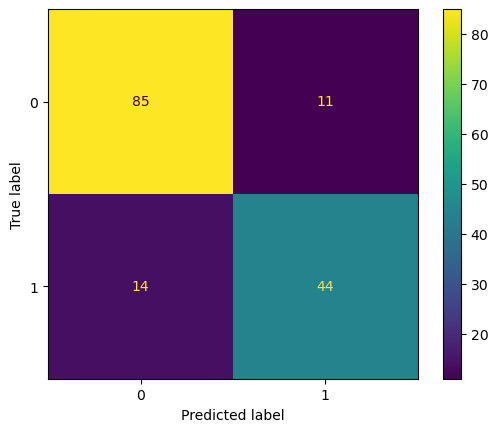

In [22]:
cm2 = confusion_matrix(y_test2, y_pred2)
ConfusionMatrixDisplay(cm2).plot()
plt.show()

In [23]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_test2, y_pred2),2))
print("Precisión:", round(precision_score(y_test2, y_pred2),2))
print("Recall:", round(recall_score(y_test2, y_pred2),2))
print("F1 score:", round(f1_score(y_test2, y_pred2),2))


Accuracy del modelo:  0.84
Precisión: 0.8
Recall: 0.76
F1 score: 0.78


In [24]:
classification_rep2 = classification_report(y_test2, y_pred2)
print(f"\nReporte de clasificación:\n{classification_rep2}")


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        96
           1       0.80      0.76      0.78        58

    accuracy                           0.84       154
   macro avg       0.83      0.82      0.83       154
weighted avg       0.84      0.84      0.84       154



**SUB SAMPLING:**   
*Vamos a utilizar un algoritmo para reducir la clase mayoritaria.

In [25]:
# Dividir los datos en características (X) y la variable objetivo (y)
X3 = df_diabetes.drop('Outcome', axis=1)  # Características
y3 = df_diabetes['Outcome']  # Variable objetivo

In [26]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2,shuffle = True,  random_state=42)

# Escalar las características

scaler = StandardScaler()
X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)

In [27]:
# Crear una instancia de NearMiss
nm = NearMiss(sampling_strategy='majority')  # 'majority' selecciona la clase mayoritaria

# Realizar el submuestreo en los conjuntos de entrenamiento
X_train_resampled, y_train_resampled = nm.fit_resample(X_train3, y_train3)

# Verificar la distribución de clases después del submuestreo
print("Distribución de clases después del submuestreo:", Counter(y_train_resampled))

Distribución de clases después del submuestreo: Counter({0: 210, 1: 210})


In [32]:
#Si introducimos nuevos datos que tienen diferentes características, distribuciones, o estructura en comparación con los datos originales, es importante entrenar un nuevo modelo para garantizar que el modelo se ajuste de manera adecuada y represente los patrones de los nuevos datos.
model3 = LogisticRegression(random_state=42)
model3.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones en el conjunto de prueba
y_pred3 = model3.predict(X_test3)

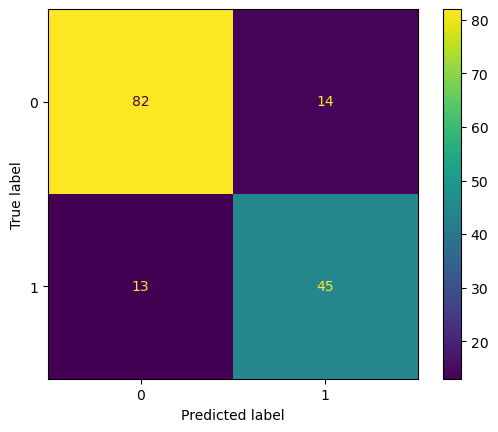

In [33]:
cm3 = confusion_matrix(y_test3, y_pred3)
ConfusionMatrixDisplay(cm3).plot()
plt.show()

In [34]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_test3, y_pred3),2))
print("Precisión:", round(precision_score(y_test3, y_pred3),2))
print("Recall:", round(recall_score(y_test3, y_pred3),2))
print("F1 score:", round(f1_score(y_test3, y_pred3),2))

Accuracy del modelo:  0.82
Precisión: 0.76
Recall: 0.78
F1 score: 0.77


In [35]:
classification_rep3 = classification_report(y_test3, y_pred3)
print(f"\nReporte de clasificación:\n{classification_rep3}")


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        96
           1       0.76      0.78      0.77        58

    accuracy                           0.82       154
   macro avg       0.81      0.82      0.81       154
weighted avg       0.83      0.82      0.82       154



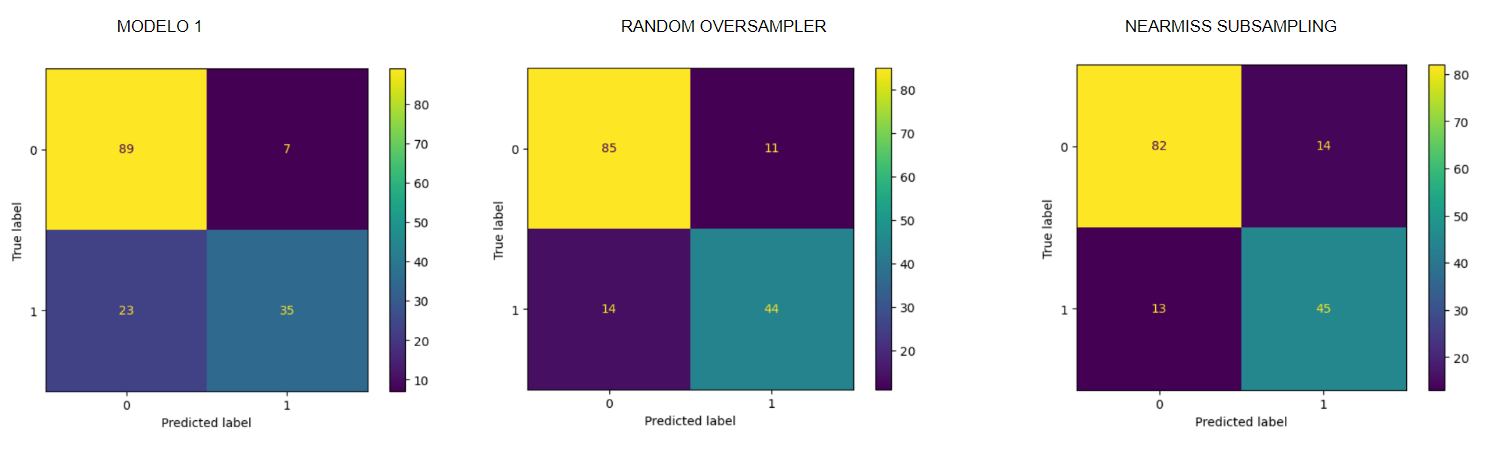

**Se observa en los gráficos que tanto con el oversampling como con subsampling se reducen los errores al predecir la clase 1. Se aprecia un pequeño incremento de errores con la clase 0. 
Si comparamos las métricas generales, con el oversampling se obtiene mejor accuracy, recall, f1 y precisión.** 